<a href="https://colab.research.google.com/github/Tofupaste/Projectbased_RNN/blob/main/projectbased_rnn_80_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import os
import torch
import scipy
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import matplotlib.dates as mdates
import statsmodels.api as sm
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
import math
import yfinance as yf
import datetime as dt

1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/RNN/train.csv')
print(len(train))
train.head()

43775


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/RNN/Test_Jan.csv')
print(len(test))
test.head()

744


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,01-01-2020 00:00,0,25.809259,0.018042,0.032806,14.849625,23.301447,0.017035,0.021866,4.559083,22.598322,0.016195,0.068054,3.737708,1,1,0
1,01-01-2020 01:00,0,25.650842,0.018065,0.053177,15.933757,23.041467,0.016936,0.023796,4.846412,22.471155,0.016104,0.080109,3.591759,1,1,0
2,01-01-2020 02:00,0,25.501489,0.018119,0.069000,16.806818,22.806177,0.016822,0.024910,5.204608,22.368677,0.016013,0.094757,3.704177,1,1,0
3,01-01-2020 03:00,0,25.430994,0.018142,0.080017,17.460632,22.657556,0.016746,0.025208,5.628076,22.282556,0.015937,0.107086,3.936592,1,1,0
4,01-01-2020 04:00,0,25.360132,0.018204,0.084137,16.632112,22.539819,0.016647,0.022789,5.729821,22.203882,0.015862,0.113800,4.088643,1,1,0


In [ ]:
predict = pd.read_csv('/content/drive/MyDrive/RNN/Predict_Jan.csv')
print(len(predict))
predict.head()

744


,datetime,nat_demand
0,01-01-2020 00:00,1032.2630
1,01-01-2020 01:00,1017.5806
2,01-01-2020 02:00,1000.2797
3,01-01-2020 03:00,987.2383
4,01-01-2020 04:00,970.3667


==== VISUALISASI DATA

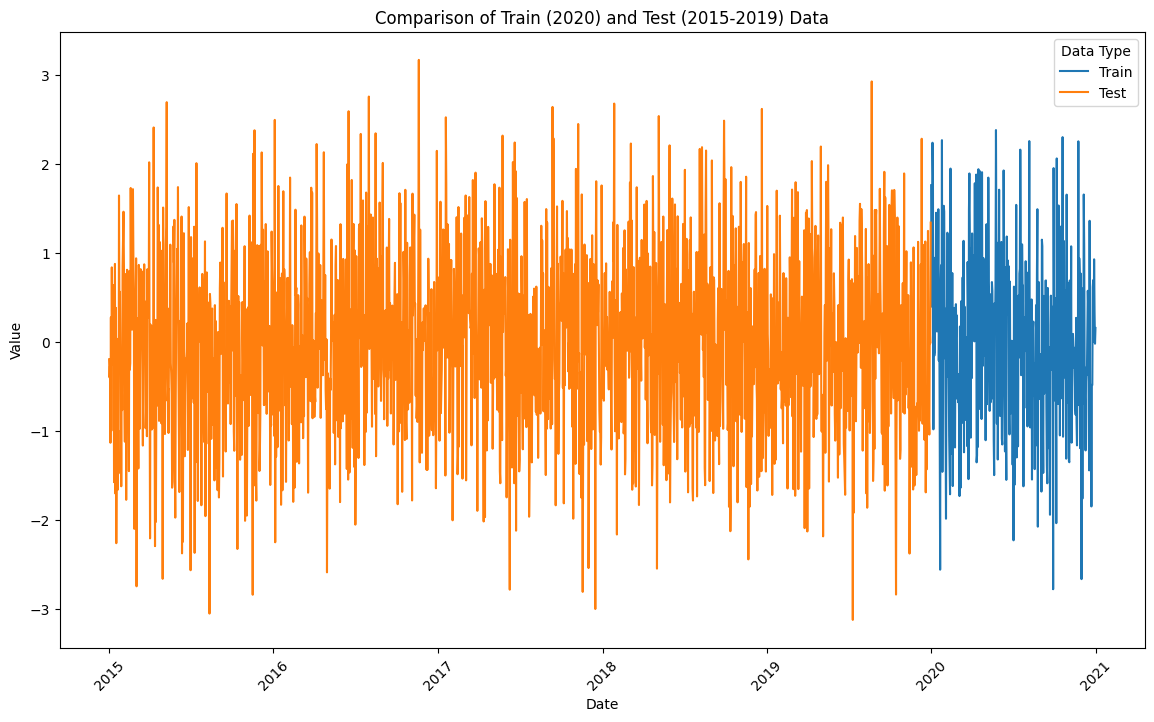

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
# Generate random data for demonstration purposes
np.random.seed(0)
train_data = np.random.randn(366)  # 2020 is a leap year

# Calculate the number of days in the test period (2015-2019)
test_period_start = pd.to_datetime('2015-01-01')
test_period_end = pd.to_datetime('2019-12-31')
num_test_days = (test_period_end - test_period_start).days + 1

test_data = np.random.randn(num_test_days)

# Generate date ranges
train_dates = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
test_dates = pd.date_range(start='2015-01-01', end='2019-12-31', freq='D')

# Ensure the lengths match
assert len(train_dates) == len(train_data)
assert len(test_dates) == len(test_data)

# Create DataFrames for easier plotting
train_df = pd.DataFrame({
    'Date': train_dates,
    'Value': train_data,
    'Type': 'Train'
})

test_df = pd.DataFrame({
    'Date': test_dates,
    'Value': test_data,
    'Type': 'Test'
})

# Combine the data
data = pd.concat([train_df, test_df])

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='Date', y='Value', hue='Type')
plt.title('Comparison of Train (2020) and Test (2015-2019) Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Data Type')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print("Holiday ID:", train['Holiday_ID'].unique())
print("Holiday:", train['holiday'].unique())
print("School:", train['school'].unique())


Holiday ID: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  1]
Holiday: [0 1]
School: [0 1]


In [ ]:
train[['Holiday_ID','holiday','school']].value_counts()

Holiday_ID  holiday  school
0           0        1         30864
                     0         10175
21          1        0           144
19          1        1           144
16          1        1           144
12          1        1           144
20          1        0           120
18          1        1           120
17          1        1           120
15          1        1           120
14          1        1           120
13          1        1           120
11          1        1           120
10          1        1           120
9           1        1           120
8           1        1           120
7           1        0           120
6           1        0           120
5           1        0           120
4           1        0           120
3           1        0           120
2           1        0           120
1           1        0           120
22          1        0           120
Name: count, dtype: int64

In [ ]:
train.index=pd.to_datetime(train['datetime'],format="%d-%m-%Y %H:%M")
train=train.drop('datetime',axis=1)

Making data into 80 / 20

In [ ]:
# setting 80% of the data as training data
import math
train_data_len = math.ceil(len(train) * .8)
train_data_len

# splitting the dataset
train_split = train[:train_data_len].iloc[:,:1]
test_split = train[train_data_len:].iloc[:,:1]
print(train_split.shape, test_split.shape)

(35020, 1) (8755, 1)


Minmax Scaller

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = scaler.fit_transform(train_split)

print(train_scaled[:5])

[[0.46624951]
 [0.42026148]
 [0.41084821]
 [0.40269331]
 [0.40564433]]


In [ ]:
test_data = test_split.iloc[:, 0].values  # Select all rows (:) and the first column (0)

# reshape to 2d array
test_data = np.reshape(test_data, (-1,1))

# applying minmax in test
test_scaled = scaler.fit_transform(test_data)
print(*test_scaled[:5])

[0.51709748] [0.50681546] [0.5030024] [0.53370453] [0.55487455]


======= Devided x_train and y_train

In [ ]:
X_train = []
y_train = []
for i in range(50, len(train_scaled)):
    X_train.append(train_scaled[i-50:i, 0])
    y_train.append(train_scaled[i, 0])
    if i <= 51:
        print(X_train)
        print(y_train)
        print()

[array([0.46624951, 0.42026148, 0.41084821, 0.40269331, 0.40564433,
       0.39421703, 0.43631996, 0.52841095, 0.62243968, 0.69327583,
       0.69096424, 0.66117288, 0.64951584, 0.64564671, 0.62330616,
       0.5977718 , 0.57029045, 0.5743192 , 0.60208002, 0.56656576,
       0.54871511, 0.52236486, 0.48940499, 0.46443717, 0.44546546,
       0.43334079, 0.41819102, 0.40640946, 0.39851276, 0.38137514,
       0.38825206, 0.42051534, 0.46581998, 0.50496097, 0.53693166,
       0.54486575, 0.55870133, 0.55860891, 0.54928908, 0.53429149,
       0.51635522, 0.56997359, 0.59814337, 0.59500696, 0.5706263 ,
       0.54707575, 0.49965258, 0.45698059, 0.43319413, 0.41185336])]
[0.40097646922005553]

[array([0.46624951, 0.42026148, 0.41084821, 0.40269331, 0.40564433,
       0.39421703, 0.43631996, 0.52841095, 0.62243968, 0.69327583,
       0.69096424, 0.66117288, 0.64951584, 0.64564671, 0.62330616,
       0.5977718 , 0.57029045, 0.5743192 , 0.60208002, 0.56656576,
       0.54871511, 0.52236486, 0.48

In [ ]:
X_test = []
y_test = []
for i in range(50, len(test_scaled)):
    X_test.append(test_scaled[i-50:i, 0])
    y_test.append(test_scaled[i, 0])
    if i <= 51:
        print(X_test)
        print(y_test)
        print()

[array([0.51709748, 0.50681546, 0.5030024 , 0.53370453, 0.55487455,
       0.56652365, 0.57572074, 0.57996751, 0.58564567, 0.5857107 ,
       0.57822238, 0.56389942, 0.55083574, 0.6140892 , 0.63623714,
       0.64958964, 0.64466897, 0.6245089 , 0.59555313, 0.5642631 ,
       0.55008259, 0.53440799, 0.51938431, 0.52059068, 0.53380756,
       0.53883774, 0.605646  , 0.71718185, 0.7693614 , 0.81412883,
       0.84827068, 0.8596163 , 0.86765549, 0.87920852, 0.85126184,
       0.79874245, 0.73713818, 0.7505975 , 0.76880503, 0.75008024,
       0.72550961, 0.69820718, 0.65063503, 0.61087565, 0.57845186,
       0.56748685, 0.55452902, 0.54579053, 0.55199254, 0.56712543])]
[0.6302397961478515]

[array([0.51709748, 0.50681546, 0.5030024 , 0.53370453, 0.55487455,
       0.56652365, 0.57572074, 0.57996751, 0.58564567, 0.5857107 ,
       0.57822238, 0.56389942, 0.55083574, 0.6140892 , 0.63623714,
       0.64958964, 0.64466897, 0.6245089 , 0.59555313, 0.5642631 ,
       0.55008259, 0.53440799, 0.519

==== Convert to numpy array

In [ ]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (34970, 50, 1) y_train : (34970, 1)


In [ ]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_test : (8705, 50, 1) y_test : (8705, 1)


===== RNN Model

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

Using simpleRNN

In [ ]:
# initializing the RNN
model = Sequential()

# adding RNN layers and dropout regularization
model.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

model.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

model.add( SimpleRNN(units = 50))

# adding the output layer
model.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
model.compile(optimizer = SGD(learning_rate=0.0001,
                                  decay=1e-6,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = "mean_squared_error")

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 50, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 50, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ (None, 50, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

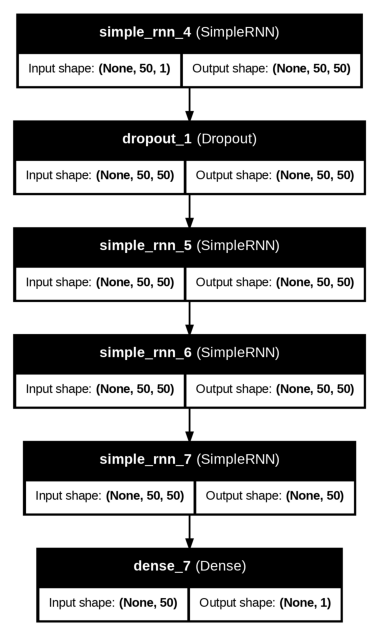

In [ ]:
# prompt: visualisasikan layer nya

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Assuming your model is named 'model' as defined in the provided code
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot in the notebook
plt.figure(figsize=(12, 8))
img = plt.imread('model_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#yang make vscode, run kan ini

# import visualkeras
# visualkeras.layered_view(model)

In [ ]:
# Mendapatkan history training
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

# Menampilkan nilai loss terbaik
best_loss = min(history.history['loss'])
print(f"Nilai loss terbaik: {best_loss}")

Epoch 1/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 106s 47ms/step - loss: 0.0208
Epoch 2/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 140s 46ms/step - loss: 0.0101
Epoch 3/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 144s 47ms/step - loss: 0.0070
Epoch 4/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 108s 49ms/step - loss: 0.0058
Epoch 5/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 105s 48ms/step - loss: 0.0050
Epoch 6/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 143s 48ms/step - loss: 0.0047
Epoch 7/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 141s 48ms/step - loss: 0.0043
Epoch 8/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 139s 46ms/step - loss: 0.0040
Epoch 9/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 141s 46ms/step - loss: 0.0037
Epoch 10/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 148s 49ms/step - loss: 0.0036
Epoch 11/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 103s 47ms/step - loss: 0.0034
Epoch 12/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 144s 48ms/step - loss: 0.0033
Epoch 13/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 141s 47ms/step - loss: 0.0032
Epoch 14/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 142s 47ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


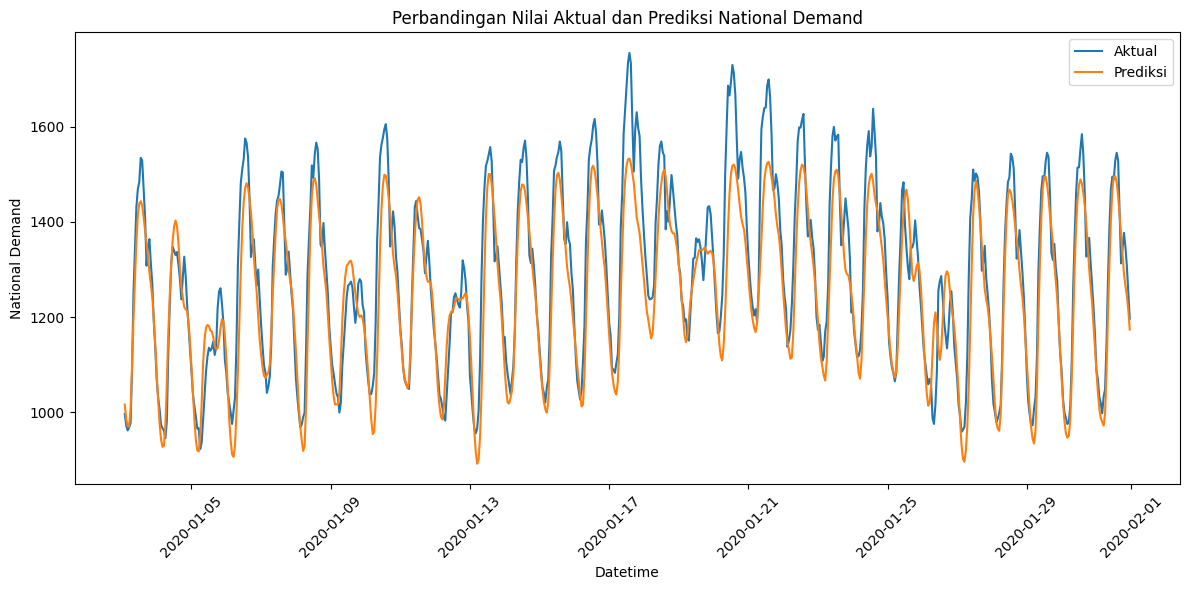

In [ ]:
import matplotlib.pyplot as plt

# Prediksi data Predict_Jan.csv
predict_scaled = scaler.transform(predict[['nat_demand']])  # Menggunakan kolom 'nat_demand'
X_predict = []
for i in range(50, len(predict_scaled)):
    X_predict.append(predict_scaled[i-50:i, 0])
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

predicted_values = model.predict(X_predict)
predicted_values = scaler.inverse_transform(predicted_values)  # Kembalikan ke skala asli

# Plot perbandingan
plt.figure(figsize=(12, 6))
plt.plot(predict['datetime'][50:], predict['nat_demand'][50:], label='Aktual')  # Menggunakan kolom 'nat_demand'
plt.plot(predict['datetime'][50:], predicted_values, label='Prediksi')
plt.xlabel('Datetime')
plt.ylabel('National Demand')  # Mengubah label y-axis
plt.title('Perbandingan Nilai Aktual dan Prediksi National Demand')  # Mengubah judul
plt.legend()
plt.xticks(rotation=45)  # Memutar label x-axis agar mudah dibaca
plt.tight_layout()  # Menyesuaikan layout agar tidak terpotong
plt.show()

===== LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


#Initialising the model
modelLSTM = Sequential()

#Adding LSTM layers
modelLSTM.add(LSTM(50,
                       return_sequences = True,
                       input_shape = (X_train.shape[1],1)))
modelLSTM.add(LSTM(50,
                       return_sequences = False))
modelLSTM.add(Dense(25))

#Adding the output layer
modelLSTM.add(Dense(1))

# Compiling the model
modelLSTM.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=["accuracy"])

# Display the model summary
modelLSTM.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

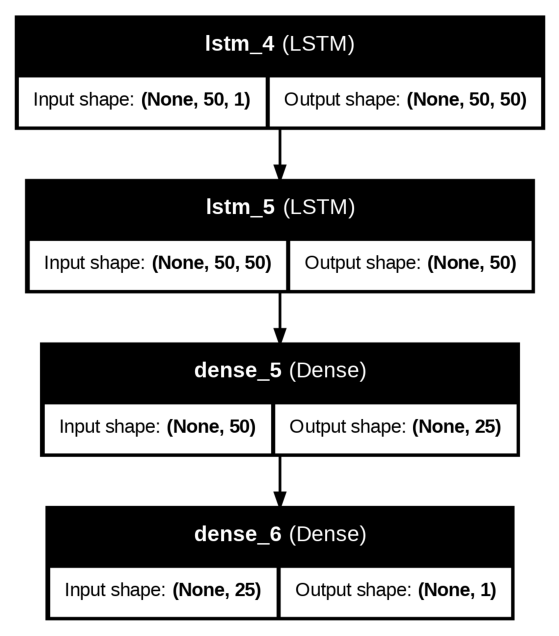

In [ ]:
# prompt: visualisasikan layer nya

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Assuming your model is named 'model' as defined in the provided code
plot_model(modelLSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot in the notebook
plt.figure(figsize=(12, 8))
img = plt.imread('model_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Fitting the model
history = modelLSTM.fit(X_train, y_train, batch_size=16, epochs=20)

# Menampilkan nilai loss terbaik
best_loss = min(history.history['loss'])
print(f"Nilai loss terbaik: {best_loss}")

Epoch 1/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 103s 45ms/step - accuracy: 4.0272e-05 - loss: 0.0329
Epoch 2/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 97s 45ms/step - accuracy: 2.3137e-05 - loss: 0.0030
Epoch 3/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 7.1802e-06 - loss: 0.0018
Epoch 4/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 143s 45ms/step - accuracy: 5.9153e-06 - loss: 0.0012
Epoch 5/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 4.3064e-06 - loss: 9.6595e-04
Epoch 6/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 1.8042e-05 - loss: 8.4004e-04
Epoch 7/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 4.6991e-05 - loss: 7.7605e-04
Epoch 8/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 4.5046e-06 - loss: 7.0115e-04
Epoch 9/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 1.8763e-05 - loss: 6.8748e-04
Epoch 10/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 142s 44ms/step - accuracy: 3.5687e-05 - loss: 6.4066e-04
Epoch 11/20
2186/2186 ━━━━━

Nilai loss terbaik: 0.0005083598662167788


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


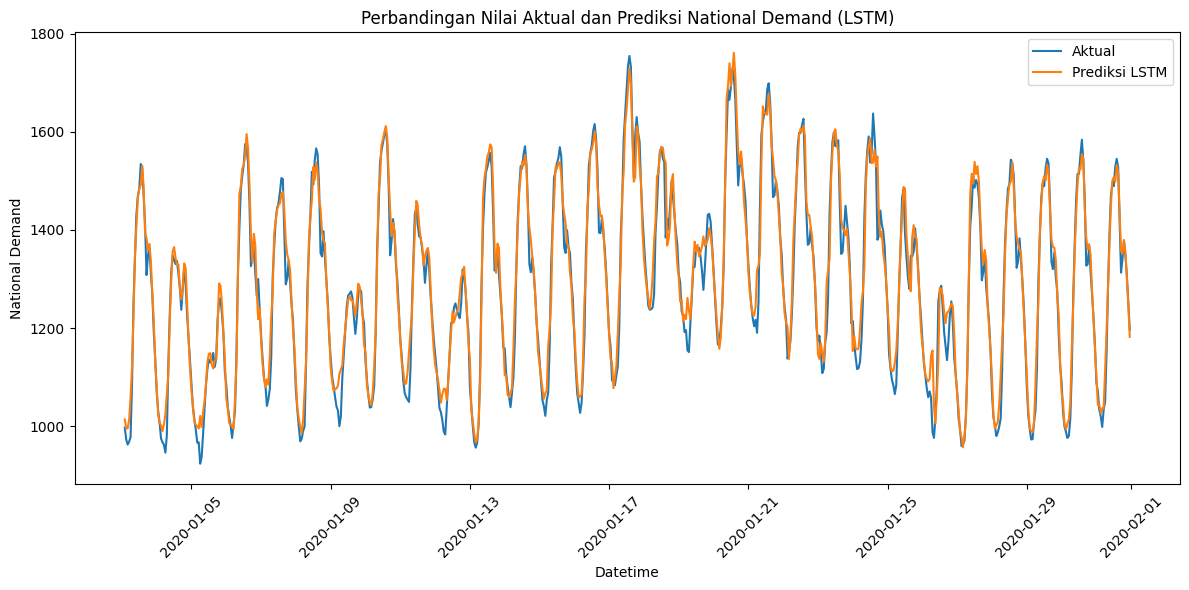

In [ ]:
# Menampilkan nilai loss terbaik
best_loss = min(history.history['loss'])
print(f"Nilai loss terbaik: {best_loss}")

# Prediksi data Predict_Jan.csv using LSTM
predict_scaled = scaler.transform(predict[['nat_demand']])
X_predict = []
for i in range(50, len(predict_scaled)):
    X_predict.append(predict_scaled[i-50:i, 0])
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

predicted_values_lstm = modelLSTM.predict(X_predict)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

# Plot perbandingan LSTM
plt.figure(figsize=(12, 6))
plt.plot(predict['datetime'][50:], predict['nat_demand'][50:], label='Aktual')
plt.plot(predict['datetime'][50:], predicted_values_lstm, label='Prediksi LSTM')
plt.xlabel('Datetime')
plt.ylabel('National Demand')
plt.title('Perbandingan Nilai Aktual dan Prediksi National Demand (LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

====== GRU RNN

In [ ]:
#Initialising the model
modelGRU = Sequential()

# GRU layers with Dropout regularisation
modelGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

modelGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

modelGRU.add(GRU(units=50,
                     activation='tanh'))

# The output layer
modelGRU.add(Dense(units=1,
                       activation='relu'))
# Compiling the RNN
modelGRU.compile(optimizer=SGD(learning_rate=0.01,
                                   decay=1e-7,
                                   momentum=0.9,
                                   nesterov=False),
                     loss='mean_squared_error')

modelGRU.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 50, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 50, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 50, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,901 (210.55 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

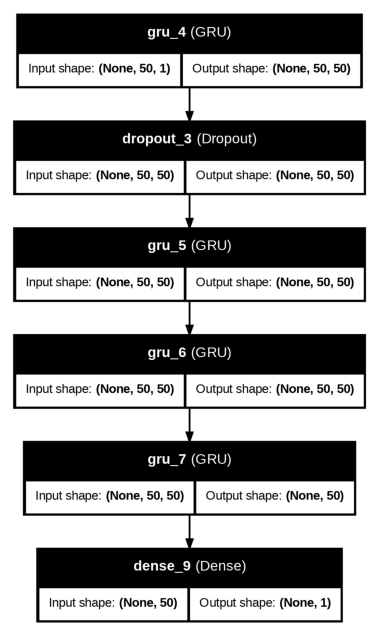

In [ ]:
# prompt: visualisasikan layer nya

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Assuming your model is named 'model' as defined in the provided code
plot_model(modelGRU, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot in the notebook
plt.figure(figsize=(12, 8))
img = plt.imread('model_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Fitting the data
history = modelGRU.fit(X_train,y_train,epochs=20,batch_size=16)

# Menampilkan nilai loss terbaik
best_loss = min(history.history['loss'])
print(f"Nilai loss terbaik: {best_loss}")

Epoch 1/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 248s 110ms/step - loss: 0.0221
Epoch 2/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 239s 109ms/step - loss: 0.0052
Epoch 3/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 267s 111ms/step - loss: 0.0038
Epoch 4/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 250s 115ms/step - loss: 0.0032
Epoch 5/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 258s 113ms/step - loss: 0.0027
Epoch 6/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 262s 113ms/step - loss: 0.0024
Epoch 7/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 262s 113ms/step - loss: 0.0022
Epoch 8/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 261s 112ms/step - loss: 0.0020
Epoch 9/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 265s 114ms/step - loss: 0.0019
Epoch 10/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 261s 113ms/step - loss: 0.0018
Epoch 11/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 261s 113ms/step - loss: 0.0018
Epoch 12/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 247s 113ms/step - loss: 0.0017
Epoch 13/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 262s 113ms/step - loss: 0.0016
Epoch 14/20
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 261s

Nilai loss terbaik: 0.0014049614546820521


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


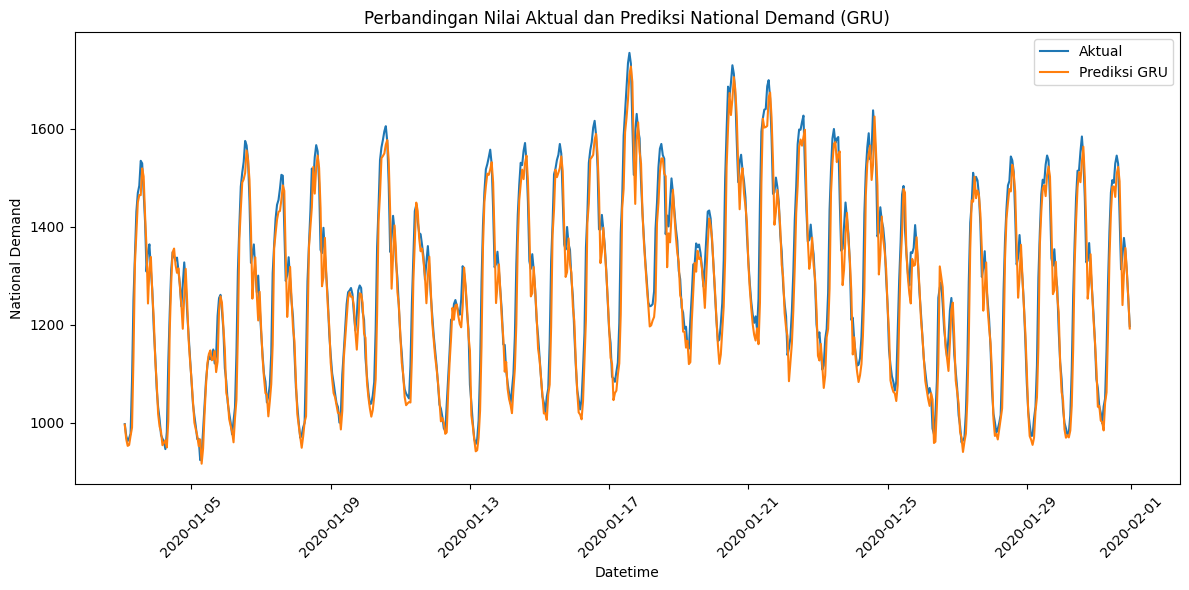

In [ ]:
# Menampilkan nilai loss terbaik
best_loss = min(history.history['loss'])
print(f"Nilai loss terbaik: {best_loss}")

# Prediksi data Predict_Jan.csv using LSTM
predict_scaled = scaler.transform(predict[['nat_demand']])
X_predict = []
for i in range(50, len(predict_scaled)):
    X_predict.append(predict_scaled[i-50:i, 0])
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

predicted_values_GRU = modelGRU.predict(X_predict)
predicted_values_GRU = scaler.inverse_transform(predicted_values_GRU)

# Plot perbandingan GRU
plt.figure(figsize=(12, 6))
plt.plot(predict['datetime'][50:], predict['nat_demand'][50:], label='Aktual')
plt.plot(predict['datetime'][50:], predicted_values_GRU, label='Prediksi GRU')
plt.xlabel('Datetime')
plt.ylabel('National Demand')
plt.title('Perbandingan Nilai Aktual dan Prediksi National Demand (GRU)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()